In [1]:
%load_ext autoreload
%reload_ext autoreload
from VehicleDetection import VehicleDetection
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import statistics
from eval_utils import *
from video_utils import *
from load_utils import *
from background_remover import *

data_path = '../../AICity_data/train/S03/c010/'

In [284]:
means, stds = get_background_stats(data_path + 'vdo.avi', 1, 535) # 535 is the 25% of the frames

100%|█████████████████████████████████████████| 534/534 [00:09<00:00, 57.89it/s]


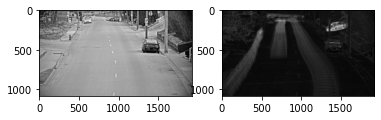

In [285]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(means, cmap='gray')
axs[1].imshow(stds, cmap='gray')

plt.show()

In [289]:
singleGaussianDetections = remove_background(means, stds, data_path + 'vdo.avi', data_path + 'roi.jpg', 4, 2.0)

 30%|███████████▉                            | 638/2141 [00:18<00:44, 33.69it/s]


KeyboardInterrupt: 

In [279]:
gt_detect = readDetectionsXML('ai_challenge_s03_c010-full_annotation.xml')
gt_notParked = getNotParkedCars(gt_detect)

In [281]:
#split detections in groups of frames
detects_1000 = {}
for frame in range(530,1000):
    if str(frame) in singleGaussianDetections and len(singleGaussianDetections[str(frame)]) > 0:
        detects_1000[str(frame)] = singleGaussianDetections[str(frame)]

detects_1000_1500 = {}
for frame in range(1000,1500):
    if str(frame) in singleGaussianDetections and len(singleGaussianDetections[str(frame)]) > 0:
        detects_1000_1500[str(frame)] = singleGaussianDetections[str(frame)]

detects_1500_end = {}
for frame in range(1500,2142):
    if str(frame) in singleGaussianDetections and len(singleGaussianDetections[str(frame)]) > 0:
        detects_1500_end[str(frame)] = singleGaussianDetections[str(frame)]

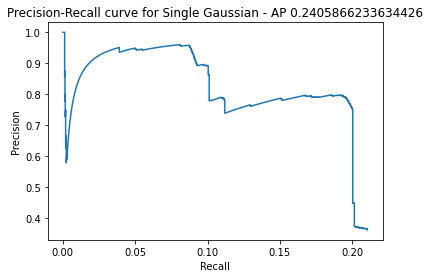

In [282]:
rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_notParked, singleGaussianDetections, 0.5, False)
plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for Single Gaussian - AP {ap}')

In [271]:
#split detections in groups of frames
gt_1000 = {}
for frame in range(530,1000):
    if str(frame) in gt_notParked and len(gt_notParked[str(frame)]) > 0:
        gt_1000[str(frame)] = gt_notParked[str(frame)]

gt_1000_1500 = {}
for frame in range(1000,1500):
    if str(frame) in gt_notParked and len(gt_notParked[str(frame)]) > 0:
        gt_1000_1500[str(frame)] = gt_notParked[str(frame)]

gt_1500_end = {}
for frame in range(1500,2142):
    if str(frame) in gt_notParked and len(gt_notParked[str(frame)]) > 0:
        gt_1500_end[str(frame)] = gt_notParked[str(frame)]

In [272]:
recs, precs, aps = ap_wo_conf(gt_1000,detects_1000)
recs2, precs2, aps2 = ap_wo_conf(gt_1000_1500,detects_1000_1500)
recs3, precs3, aps3 = ap_wo_conf(gt_1500_end,detects_1500_end)
recs4, precs4, aps4 = ap_wo_conf(gt_notParked,singleGaussianDetections)


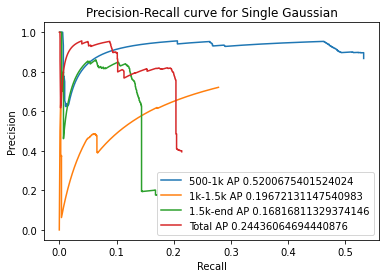

In [273]:
tests = [np.mean(precs, axis=0), np.mean(precs2, axis=0), np.mean(precs3, axis=0), np.mean(precs4, axis=0)]
labels = [f'500-1k AP {np.mean(aps)}', f'1k-1.5k AP {np.mean(aps2)}', f'1.5k-end AP {np.mean(aps3)}', f'Total AP {np.mean(aps4)}']
plot_multiple_prec_recall_curves(tests, [recs[0], recs2[0], recs3[0], recs4[0]], labels, f'Precision-Recall curve for Single Gaussian')

In [276]:
alphas = np.linspace(2.0, 15.0, num=8)
precs, recs, lables = [], [], []
for alpha in alphas:
    singleGaussianDetections = remove_background2(means,stds, data_path + 'vdo.avi', data_path + 'roi.jpg', alpha, 2.0)
    rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_notParked, singleGaussianDetections, 0.5, False)
    print(f'With Alpha {alpha} the AP is {ap}')
    lables.append(f'Alpha {alpha:.2f}')
    precs.append(prec)
    recs.append(rec)

plot_multiple_prec_recall_curves(precs, recs, lables, f'Precision-Recall curve for Single Gaussian - AP {ap}')

100%|███████████████████████████████████████| 2141/2141 [04:49<00:00,  7.40it/s]


With Alpha 2.0 the AP is 0.10943127399374679


 86%|█████████████████████████████████▍     | 1837/2141 [03:37<00:36,  8.43it/s]


KeyboardInterrupt: 

In [ ]:
generate_videoBB_comparison(data_path + 'vdo.avi', gt_detect, singleGaussianDetections, 'gaussDetector500-1000', 536, 1000)

In [ ]:
generate_videoBB_comparison(data_path + 'vdo.avi', gt_detect, singleGaussianDetections, 'gaussDetector1000-1500', 1000, 1500)

In [ ]:
generate_videoBB_comparison(data_path + 'vdo.avi', gt_detect, singleGaussianDetections, 'gaussDetector1500-2000', 1500, 2140)